<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'> Notas iniciales </font>

<font color='lightgreen'> Referencias </font>

* Proyecto que usa mismo conjunto de datos [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* Artículo que usa mismo conjunto de datos [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)
*    [Documentación de Hugging Face](https://huggingface.co/)


In [1]:
!git clone https://github.com/Albmargar1/ClickbaitDetector

fatal: destination path 'ClickbaitDetector' already exists and is not an empty directory.


In [2]:
!pip install transformers

In [3]:
!pip install datasets folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

In [4]:
import datasets
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
from datasets import load_metric
import torch

In [5]:
class bcolors:
    blue = '\033[34m'
    endc = '\033[0m'

# <font color='orange'> Hiperparámetros </font>

In [6]:
train_val_split = 0.15
batch_size = 32
num_epochs = 6
training = True
validation = True

plt.rcParams['font.size'] = '13'
columns_to_keep = ["attention_mask", "input_ids", "labels", "token_type_ids"]

checkpoint = 'elozano/bert-base-cased-clickbait-news'#"bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# <font color='orange'> Carga y manipulación inicial de datos </font>

Los datos se cargarán a través de pandas, se realizará un procesamiento básico y se transformará en un dataset apto para los transformers de Hugging Face. Dado que los datos se encuentran en dos archivos diferentes, se procesan a través de una función.

In [7]:
def process_data(data_dir):
  data = pd.read_csv(data_dir)

  # Drop non-necessary columns
  # data = data[columns_to_keep]

  # Some features have null values
  for n in data.columns:
    data.loc[data[n].isna(), n] = ''

  return data

train_dir = '/content/ClickbaitDetector/data/webis_train.csv'
test_dir = '/content/ClickbaitDetector/data/webis_test.csv'

data_train = process_data(train_dir)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         19538 non-null  object
 1   postMedia          19538 non-null  object
 2   postText           19538 non-null  object
 3   id                 19538 non-null  object
 4   targetCaptions     19538 non-null  object
 5   targetParagraphs   19538 non-null  object
 6   targetTitle        19538 non-null  object
 7   postTimestamp      19538 non-null  object
 8   targetKeywords     19538 non-null  object
 9   targetDescription  19538 non-null  object
 10  truthJudgments     19538 non-null  object
 11  truthMean          19538 non-null  object
 12  truthClass         19538 non-null  object
 13  truthMedian        19538 non-null  object
 14  truthMode          19538 non-null  object
dtypes: object(15)
memory usage: 2.2+ MB


# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait



In [8]:
legit_tweets = data_train[data_train['truthClass'] == 'no-clickbait']
clickbait_tweets = data_train[data_train['truthClass'] == 'clickbait']

legit_count = legit_tweets.shape[0]
clickbait_count = clickbait_tweets.shape[0]
bad_labeled_count = data_train.shape[0] - (legit_count + clickbait_count)
clickbait_proportion = clickbait_count/(clickbait_count + legit_count+bad_labeled_count)

print(bcolors.blue,
      '\nTweets legítimos:', legit_count, 
      '\nTweets clickbait:', clickbait_count, 
      '\nTweets mal etiquetados:', bad_labeled_count,
      '\nProporción tweets clickbait:', clickbait_proportion, 
      bcolors.endc)

 
Tweets legítimos: 14777 
Tweets clickbait: 4761 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24367898454294196 


<font color='lightgreen'> Variabilidad de los anotadores </font>

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.


 
Media de la desviación típica:  0.24123968822483477 
Desviación típica de la desviación típica: 0.12232780206176876 
 


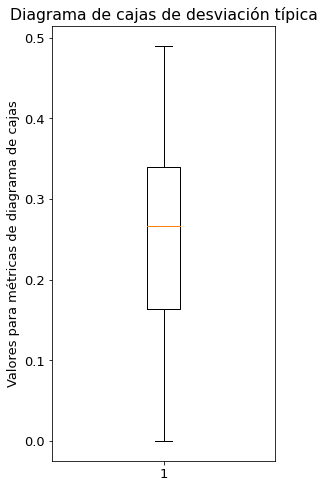

In [9]:
truth_judgments = [eval(row) for row in data_train['truthJudgments']]
truth_judgments = np.array(truth_judgments)
truth_mean = np.mean(truth_judgments, axis=1)
truth_std = np.std(truth_judgments, axis=1)
print(bcolors.blue, '\nMedia de la desviación típica: ', np.mean(truth_std), '\nDesviación típica de la desviación típica:', np.std(truth_std), '\n',bcolors.endc)

f, ax = plt.subplots(figsize=(4,8))
plt.boxplot(truth_std)
ax.set_ylabel('Valores para métricas de diagrama de cajas')
plt.title('Diagrama de cajas de desviación típica')
plt.show()

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

*Nota: Esta idea la he sacado de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*

<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

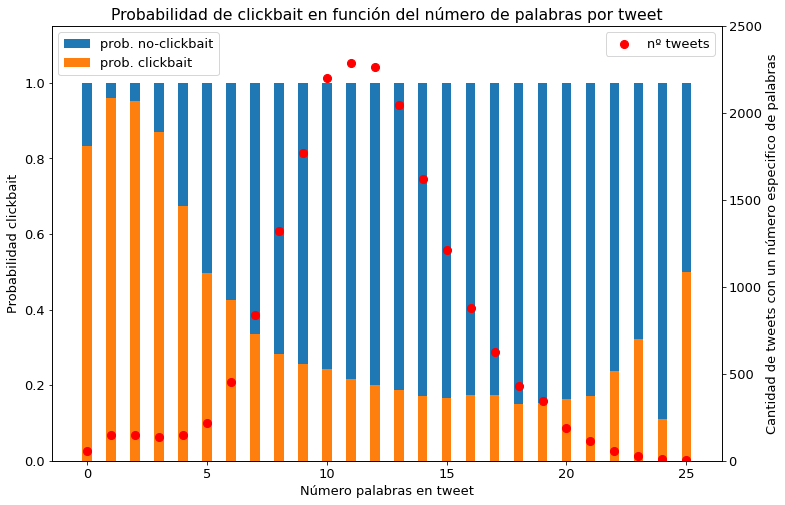

In [10]:
tweets_clickbaits = data_train['postText'].mask(data_train['truthClass']=='no-clickbait').dropna().reset_index(drop=True).str.split()
tweets_noclickbaits = data_train['postText'].mask(data_train['truthClass']=='clickbait').dropna().reset_index(drop=True).str.split()
assert tweets_clickbaits.shape[0] + tweets_noclickbaits.shape[0] == data_train.shape[0], 'Error, hay etiquetas diferentes de \'clickbait\' y \'no-clickbait\''

clickbaits_word_len = list(tweets_clickbaits.str.len())
noclickbaits_word_len = list(tweets_noclickbaits.str.len())
max_tweet_word_len = max(max(clickbaits_word_len), max(noclickbaits_word_len))

dic_clickbaits_word_freq = {i: clickbaits_word_len.count(i) for i in range(max_tweet_word_len+1)}
dic_noclickbaits_word_freq = {i: noclickbaits_word_len.count(i) for i in range(max_tweet_word_len+1)}
assert sum(dic_clickbaits_word_freq.values()) + sum(dic_noclickbaits_word_freq.values()) == data_train.shape[0], 'Error al contabilizar frecuencias'

x = dic_clickbaits_word_freq.keys()
dic_tweets_word_freq = [dic_clickbaits_word_freq[i] + dic_noclickbaits_word_freq[i] for i in range(max_tweet_word_len+1)]
y1 = [dic_clickbaits_word_freq[i]   / dic_tweets_word_freq[i] for i in x] 
y2 = [dic_noclickbaits_word_freq[i] / dic_tweets_word_freq[i] for i in x] 

# Plot
f, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.bar(x, 1, 0.4, label = 'prob. no-clickbait')
ax1.bar(x, y1, 0.4, label = 'prob. clickbait')
ax2.scatter(x, dic_tweets_word_freq, color='red', s=65, label = 'nº tweets')
ax1.set_xlabel("Número palabras en tweet")
ax1.set_ylabel("Probabilidad clickbait")
ax2.set_ylabel("Cantidad de tweets con un número especifico de palabras")
plt.title("Probabilidad de clickbait en función del número de palabras por tweet")
ax1.legend(loc="upper left")
ax2.legend()
ax1.set_ylim([0, 1.15])
ax2.set_ylim([0, 2500])
plt.show()

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

<font color='lightgreen'> Probabilidad de que la palabra pertenezca a un clickbait </font>

Text(0.5, 1.0, 'Probabilidad de que la palabra pertenezca a un tweet clickbait')

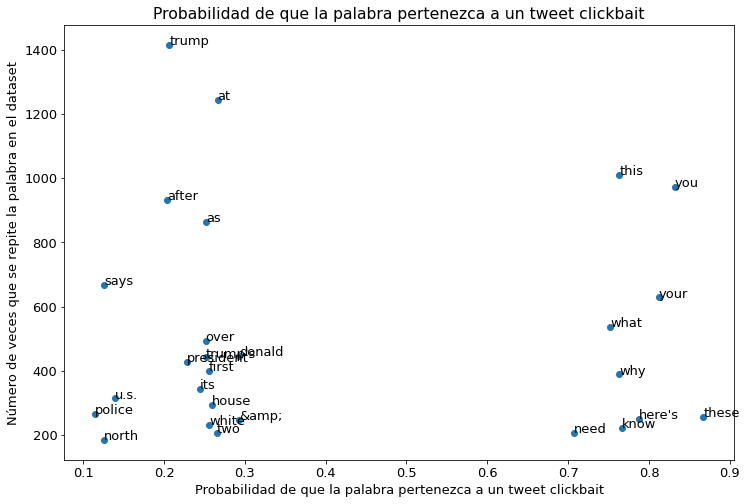

In [11]:
def build_frequency(dataframe, column_label):
  counter = Counter()
  dataframe[column_label].str.lower().str.split().apply(counter.update)
  return counter

def build_probabilities(counter, vocab):
  counter_all_words_freq = sum(counter.values())
  vocab_length = len(vocab)
  prob = {k: (counter.get(k, 0) + 1) / (counter_all_words_freq + vocab_length) for k in vocab.keys()}

  return prob

def sigmoid(x):
  return 1/(1 + np.exp(-x))

legit_tweets = data_train[data_train['truthClass'] == 'no-clickbait']
clickbait_tweets = data_train[data_train['truthClass'] == 'clickbait']

vocab_freq = build_frequency(data_train, 'postText')
legit_freq = build_frequency(legit_tweets, 'postText')
clickbait_freq = build_frequency(clickbait_tweets, 'postText')
  
legit_word_prob = build_probabilities(legit_freq, vocab_freq)
clickbait_word_prob = build_probabilities(clickbait_freq, vocab_freq)

loglikelihood = {k: np.log(clickbait_word_prob.get(k) / legit_word_prob.get(k)) for k in vocab_freq.keys()}
keys_list = [k for k in vocab_freq.keys()]
word_loglikelihood_array = np.array([sigmoid(v) for v in loglikelihood.values()])
word_count_array = np.array([v for v in vocab_freq.values()])

mask = (word_count_array > 180) & (abs(word_loglikelihood_array - 0.5) > 0.2)
mask_keys = {i: keys_list[i] for i in range(mask.shape[0]) if mask[i] == True}

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(word_loglikelihood_array[mask], word_count_array[mask])
for k,v in mask_keys.items():
  ax.annotate(v, (word_loglikelihood_array[k], word_count_array[k]))
ax.set_xlabel('Probabilidad de que la palabra pertenezca a un tweet clickbait')
ax.set_ylabel('Número de veces que se repite la palabra en el dataset')
plt.title('Probabilidad de que la palabra pertenezca a un tweet clickbait')

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

# <font color='orange'> Hugging Face dataset y tokenización </font>

In [12]:
data_train['truthClass'][data_train['truthClass'] == 'clickbait'] = 1
data_train['truthClass'][data_train['truthClass'] == 'no-clickbait'] = 0
data_train.rename(columns = {'truthClass':'labels'}, inplace = True)

In [13]:
train_data_dic = datasets.Dataset.from_pandas(data_train)
temp = train_data_dic.train_test_split(test_size = train_val_split)
data_dic = datasets.DatasetDict({'train': temp['train'],'val': temp['test']})
print(data_dic)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'postMedia', 'postText', 'id', 'targetCaptions', 'targetParagraphs', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'truthJudgments', 'truthMean', 'labels', 'truthMedian', 'truthMode'],
        num_rows: 16607
    })
    val: Dataset({
        features: ['Unnamed: 0', 'postMedia', 'postText', 'id', 'targetCaptions', 'targetParagraphs', 'targetTitle', 'postTimestamp', 'targetKeywords', 'targetDescription', 'truthJudgments', 'truthMean', 'labels', 'truthMedian', 'truthMode'],
        num_rows: 2931
    })
})


In [14]:
def tokenize_function(dataset):
    return tokenizer(dataset["postText"], truncation=True)

tokenized_datasets = data_dic.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [15]:
for d in tokenized_datasets.keys():
  for k in tokenized_datasets[d].features:
    if k not in columns_to_keep:
      tokenized_datasets[d] = tokenized_datasets[d].remove_columns(k)

In [16]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator)

eval_dataloader = DataLoader(
    tokenized_datasets["val"], batch_size=batch_size, collate_fn=data_collator)

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [18]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
  if training:
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  if validation:
    metric = load_metric("glue", "mrpc")
    model.eval()
    for batch in eval_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
        outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

    results = metric.compute()
    print(results)

  0%|          | 0/3114 [00:00<?, ?it/s]

{'accuracy': 0.8539747526441488, 'f1': 0.6403361344537815}


In [ ]:
torch.cuda.empty_cache()